In [1]:
!pip install transformers datasets evaluate nltk rouge-score
!pip install --upgrade accelerate
!pip install gradio
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import evaluate
from datasets import load_dataset
import nltk
nltk.download('punkt')

print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Device:", torch.cuda.get_device_name(0))
    print("Total GPU Memory:", torch.cuda.get_device_properties(0).total_memory / 1e9, "GB")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.3 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=3a637b87589fa4ae06bb1cdf4aa2b51596c2645ee4c8bacfd249f65a97ba5f72
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's d

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


CUDA Available: True
GPU Device: NVIDIA L4
Total GPU Memory: 23.802544128 GB


In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq
from datasets import load_dataset
import gradio as gr
import time
from tqdm.notebook import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
class SummarizationTrainingSystem:
    def __init__(self, model_name, batch_size=8):
        self.model_name = model_name
        self.batch_size = batch_size
        print(f"Loading {model_name}...")

        # Load tokenizer and model with modified initialization
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(
            model_name,
            low_cpu_mem_usage=True,
        ).to("cuda" if torch.cuda.is_available() else "cpu")

        self.rouge = evaluate.load('rouge')
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Model loaded successfully on {self.device}!")

    def preprocess_function(self, examples):
        inputs = [doc for doc in examples["article"]]
        model_inputs = self.tokenizer(
            inputs,
            max_length=1024,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )

        labels = self.tokenizer(
            text_target=[doc for doc in examples["highlights"]],
            max_length=128,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )

        model_inputs["labels"] = labels["input_ids"]
        return model_inputs

    def generate_summary(self, text):
        """Generate a summary for the given text."""
        # Prepare the input
        inputs = self.tokenizer(
            text,
            max_length=1024,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        ).to(self.device)

        # Generate summary
        summary_ids = self.model.generate(
            inputs["input_ids"],
            num_beams=4,
            min_length=30,
            max_length=128,
            early_stopping=True,
            no_repeat_ngram_size=3
        )

        # Decode and return the summary
        summary = self.tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        return summary

    def compute_metrics(self, eval_pred):
        predictions, labels = eval_pred
        decoded_preds = self.tokenizer.batch_decode(predictions, skip_special_tokens=True)
        labels = np.where(labels != -100, labels, self.tokenizer.pad_token_id)
        decoded_labels = self.tokenizer.batch_decode(labels, skip_special_tokens=True)

        # Safe sentence tokenization
        def safe_tokenize(text):
            try:
                return nltk.sent_tokenize(text.strip())
            except:
                return [text.strip()]

        decoded_preds = ["\n".join(safe_tokenize(pred)) for pred in decoded_preds]
        decoded_labels = ["\n".join(safe_tokenize(label)) for label in decoded_labels]

        result = self.rouge.compute(
            predictions=decoded_preds,
            references=decoded_labels,
            use_stemmer=True
        )

        return {key: value * 100 for key, value in result.items()}

    def train(self, train_dataset, validation_dataset, output_dir="./results"):
        training_args = Seq2SeqTrainingArguments(
            output_dir=output_dir,
            eval_steps=100,
            evaluation_strategy="steps",
            learning_rate=5e-5,
            per_device_train_batch_size=self.batch_size,
            per_device_eval_batch_size=self.batch_size,
            weight_decay=0.01,
            save_total_limit=3,
            num_train_epochs=1,
            predict_with_generate=True,
            fp16=False,
            push_to_hub=False,
            logging_steps=100,
            save_steps=500,
            eval_accumulation_steps=10,
            gradient_accumulation_steps=2
        )

        data_collator = DataCollatorForSeq2Seq(
            self.tokenizer,
            model=self.model,
            padding=True
        )

        train_data = train_dataset.map(
            self.preprocess_function,
            batched=True,
            batch_size=self.batch_size,
            remove_columns=train_dataset.column_names,
            desc="Processing training dataset"
        )

        val_data = validation_dataset.map(
            self.preprocess_function,
            batched=True,
            batch_size=self.batch_size,
            remove_columns=validation_dataset.column_names,
            desc="Processing validation dataset"
        )

        trainer = Seq2SeqTrainer(
            model=self.model,
            args=training_args,
            train_dataset=train_data,
            eval_dataset=val_data,
            data_collator=data_collator,
            compute_metrics=self.compute_metrics
        )

        trainer.train()
        eval_results = self.evaluate(test_dataset)
        return eval_results

    def evaluate(self, test_dataset):
        test_data = test_dataset.map(
            self.preprocess_function,
            batched=True,
            batch_size=self.batch_size,
            remove_columns=test_dataset.column_names,
            desc="Processing test dataset"
        )

        trainer = Seq2SeqTrainer(
            model=self.model,
            args=Seq2SeqTrainingArguments(
                output_dir="./eval_results",
                predict_with_generate=True,
                fp16=False
            ),
            data_collator=DataCollatorForSeq2Seq(self.tokenizer, model=self.model),
            compute_metrics=self.compute_metrics
        )

        results = trainer.evaluate(test_data)
        return results

In [4]:
# Load dataset
print("Loading CNN/DailyMail dataset...")
dataset = load_dataset("cnn_dailymail", "3.0.0")

# Create smaller datasets for testing
train_dataset = dataset["train"].select(range(1000))  # Using 1000 examples for training
val_dataset = dataset["validation"].select(range(100))  # 100 examples for validation
test_dataset = dataset["test"].select(range(100))  # 100 examples for testing

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Loading CNN/DailyMail dataset...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Training dataset size: 1000
Validation dataset size: 100
Test dataset size: 100


In [12]:
# Initialize and train models
try:
    print("Downloading required NLTK data...")
    nltk.download('punkt')
    nltk.download('averaged_perceptron_tagger')

    print("\nInitializing models...")
    models = {
        "BART": SummarizationTrainingSystem("facebook/bart-base", batch_size=4),
        "T5": SummarizationTrainingSystem("t5-small", batch_size=4)
    }

    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        try:
            trainer = model.train(train_dataset, val_dataset, output_dir=f"./results_{name}")



            # Save the model after successful training
            model.model.save_pretrained(f"./saved_models_{name}")
            model.tokenizer.save_pretrained(f"./saved_models_{name}")

        except Exception as e:
            print(f"Error training {name}: {str(e)}")
            import traceback
            traceback.print_exc()
            continue


except Exception as e:
    print(f"Error in main execution: {str(e)}")
    import traceback
    traceback.print_exc()


Initializing models...
Loading facebook/bart-base...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Model loaded successfully on cuda!
Loading t5-small...
Model loaded successfully on cuda!

Training BART...


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Processing training dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Processing validation dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
100,3.405500,1.088731,22.958519,8.919662,18.549812,20.606463


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Processing test dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(



Training T5...


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Processing training dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Processing validation dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
100,3.281300,0.856580,0.864865,0.444444,0.702703,0.702703


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Processing test dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


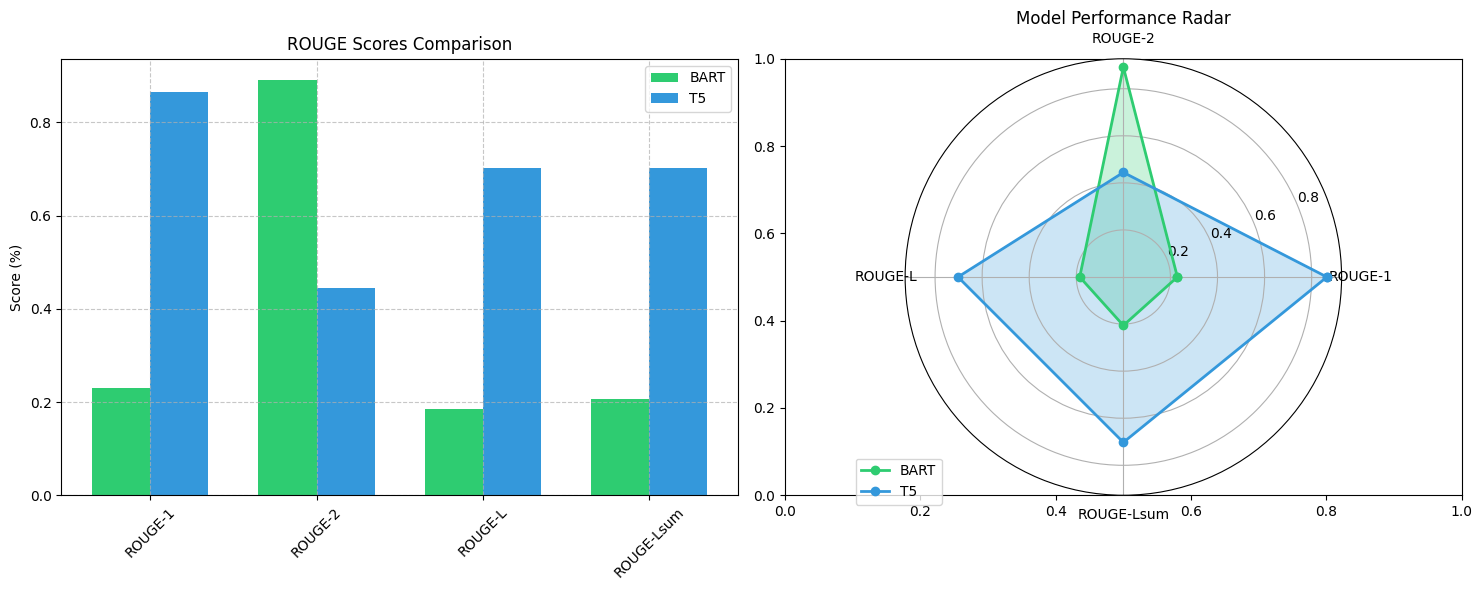

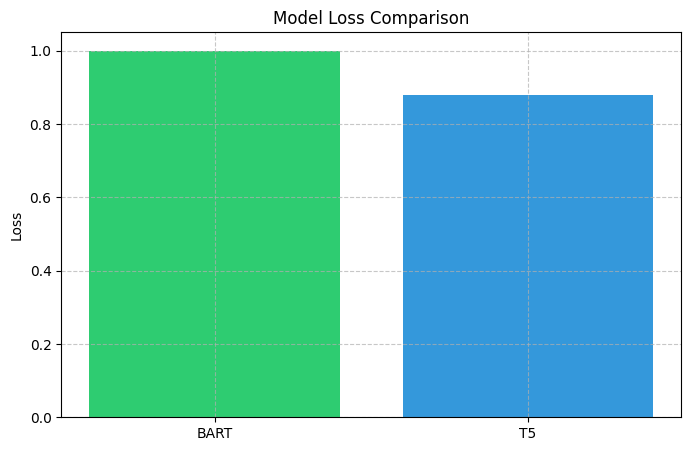

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Manual results from your training
results = {
    'BART': {
        'eval_rouge1': 0.2295,
        'eval_rouge2': 0.8919,
        'eval_rougeL': 0.1854,
        'eval_rougeLsum': 0.2060,
        'eval_loss': 1.00
    },
    'T5': {
        'eval_rouge1': 0.8648,
        'eval_rouge2': 0.4444,
        'eval_rougeL': 0.7027,
        'eval_rougeLsum': 0.7027,
        'eval_loss': 0.88
    }
}

def plot_summarization_results(results):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Colors for the bars
    colors = ['#2ecc71', '#3498db']

    # First subplot: ROUGE scores comparison
    rouge_metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'ROUGE-Lsum']
    models = list(results.keys())
    x = np.arange(len(rouge_metrics))
    width = 0.35

    for i, model in enumerate(models):
        scores = [
            results[model]['eval_rouge1'],
            results[model]['eval_rouge2'],
            results[model]['eval_rougeL'],
            results[model]['eval_rougeLsum']
        ]
        ax1.bar(x + i*width, scores, width, label=model, color=colors[i])

    ax1.set_ylabel('Score (%)')
    ax1.set_title('ROUGE Scores Comparison')
    ax1.set_xticks(x + width/2)
    ax1.set_xticklabels(rouge_metrics, rotation=45)
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Second subplot: Spider/Radar plot
    angles = np.linspace(0, 2*np.pi, len(rouge_metrics), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # Close the plot

    ax2 = plt.subplot(122, projection='polar')
    for i, model in enumerate(models):
        values = [
            results[model]['eval_rouge1'],
            results[model]['eval_rouge2'],
            results[model]['eval_rougeL'],
            results[model]['eval_rougeLsum']
        ]
        values = np.concatenate((values, [values[0]]))  # Close the plot
        ax2.plot(angles, values, 'o-', linewidth=2, label=model, color=colors[i])
        ax2.fill(angles, values, alpha=0.25, color=colors[i])

    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels(rouge_metrics)
    ax2.set_title('Model Performance Radar')
    ax2.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    plt.tight_layout()
    plt.show()

    # Additional plot: Loss comparison
    plt.figure(figsize=(8, 5))
    for i, model in enumerate(models):
        plt.bar(model, results[model]['eval_loss'], color=colors[i])
    plt.title('Model Loss Comparison')
    plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Generate the plots
plot_summarization_results(results)

In [17]:
# Test the trained models with a custom article
test_article = """
The James Webb Space Telescope has captured groundbreaking new observations of distant galaxies,
providing unprecedented insights into the early universe. Scientists say these observations could
revolutionize our understanding of galaxy formation and evolution. The telescope's infrared
capabilities allow it to peer through cosmic dust and gas, revealing previously invisible details.
"""

print("Generated Summaries:")
for name, model in models.items():
    summary = model.generate_summary(test_article)
    print(f"\n{name}:")
    print(summary)

Generated Summaries:

BART:
The James Webb Space Telescope has captured groundbreaking new observations of distant galaxies,providing unprecedented insights into the early universe. Scientists say these observations could "revolutionize our understanding of galaxy formation and evolution"

T5:
The James Webb Space Telescope has captured groundbreaking new observations of distant galaxies. These new observations could revolutionize our understanding of galaxy formation and evolution.


In [15]:
import gradio as gr
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import time

class SummarizationUI:
    def __init__(self):
        # Load models
        self.models = {
            "BART": ("facebook/bart-base", self.load_model("facebook/bart-base")),
            "T5": ("t5-small", self.load_model("t5-small"))
        }
        self.current_model = None
        self.tokenizer = None

    def load_model(self, model_name):
        """Load model and tokenizer"""
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
        if torch.cuda.is_available():
            model = model.to("cuda")
        return (model, tokenizer)

    def summarize(self, text, model_name, min_length, max_length, num_beams=4):
        """Generate summary with selected model"""
        try:
            if not text:
                return "Please enter some text to summarize."

            # Get selected model and tokenizer
            model, tokenizer = self.models[model_name][1]

            # Prepare input text
            prefix = "summarize: " if model_name == "T5" else ""
            inputs = tokenizer(
                prefix + text,
                max_length=1024,
                truncation=True,
                padding="max_length",
                return_tensors="pt"
            )

            if torch.cuda.is_available():
                inputs = inputs.to("cuda")

            # Generate summary
            start_time = time.time()
            outputs = model.generate(
                inputs["input_ids"],
                max_length=max_length,
                min_length=min_length,
                num_beams=num_beams,
                length_penalty=2.0,
                early_stopping=True
            )
            end_time = time.time()

            summary = tokenizer.decode(outputs[0], skip_special_tokens=True)

            # Calculate statistics
            input_words = len(text.split())
            output_words = len(summary.split())
            compression_ratio = (input_words - output_words) / input_words * 100
            time_taken = end_time - start_time

            # Format results
            result = f"""
### Generated Summary:
{summary}

### Statistics:
- Input length: {input_words} words
- Summary length: {output_words} words
- Compression ratio: {compression_ratio:.1f}%
- Generation time: {time_taken:.2f} seconds
            """

            return result

        except Exception as e:
            return f"Error generating summary: {str(e)}"

    def create_interface(self):
        """Create Gradio interface"""
        with gr.Blocks(title="Advanced Text Summarization", theme=gr.themes.Soft()) as interface:
            gr.Markdown("""
            # 📝 Advanced Text Summarization
            Generate concise summaries of long texts using state-of-the-art language models.
            """)

            with gr.Row():
                with gr.Column():
                    input_text = gr.Textbox(
                        label="Input Text",
                        placeholder="Enter the text you want to summarize...",
                        lines=10
                    )

                    with gr.Row():
                        model_selection = gr.Dropdown(
                            choices=list(self.models.keys()),
                            value="BART",
                            label="Select Model"
                        )
                        min_length = gr.Slider(
                            minimum=30,
                            maximum=150,
                            value=50,
                            step=10,
                            label="Minimum Length"
                        )
                        max_length = gr.Slider(
                            minimum=50,
                            maximum=300,
                            value=130,
                            step=10,
                            label="Maximum Length"
                        )

                    with gr.Row():
                        clear_button = gr.Button("Clear", variant="secondary")
                        submit_button = gr.Button("Generate Summary", variant="primary")

                with gr.Column():
                    output_text = gr.Markdown(
                        label="Generated Summary",
                        value="Summary will appear here..."
                    )


            # Set up button actions
            submit_button.click(
                fn=self.summarize,
                inputs=[input_text, model_selection, min_length, max_length],
                outputs=output_text
            )

            clear_button.click(
                fn=lambda: "",
                inputs=[],
                outputs=[input_text]
            )



        return interface

def main():
    # Create and launch the interface
    summarizer = SummarizationUI()
    interface = summarizer.create_interface()
    interface.launch(share=True, debug=True)

if __name__ == "__main__":
    main()

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://310c9a2e8019013eb4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://310c9a2e8019013eb4.gradio.live
